<a href="https://www.kaggle.com/code/syerramilli/planttraits-efficientnet-image-tabular?scriptVersionId=177876060" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

In this notebook we will train a baseline multi-output regression model in Keras on the images and the ancillary data (satellite data, soil data, climate data etc.) to predict the 6 plant properties.

**CHANGELOG**:

v1 -> v2: 
1. Replaced EfficientNet V1 with V2
2. Removed the rescaling layer prior to EfficientNet. This layer was erroneously included.

v2 -> v3:
Increased the number of training epochs (10 -> 15)

v3 -> v4:
1. Further Increased the number of training epochs (15 -> 25)
2. Set the number of warmup steps as a percentage (20%) of the total number of optimization steps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

2024-05-15 19:51:11.036796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 19:51:11.036899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 19:51:11.171402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## global configuration
CFG = {
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 25,
    'MAX_LR': 5e-4,
    'WARMUP_PCT': 0.2,
    'n_tabular_layers': 2,
    'img_backbone_final_dim': 128,
    'tabular_hsizes': [256, 128],
    'n_ff_layers': 2,
    'ff_hsizes': [128, 64]
}

## Loading the data

In [3]:
path = Path('/kaggle/input/planttraits2024/')
imgs_train = path / 'train_images'
imgs_test = path / 'test_images'

train = pd.read_csv(path / 'train.csv')
train['img_path'] = train['id'].apply(lambda x: imgs_train / f'{x}.jpeg')

test = pd.read_csv(path / 'test.csv')
test['img_path'] = test['id'].apply(lambda x: imgs_test / f'{x}.jpeg')

In [4]:
targets = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']
target_cols = [f'{col}_mean' for col in targets]
target_cols

['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [5]:
# remove sd columns
sd_cols = [f'{col}_sd' for col in targets]
train = train.drop(columns = sd_cols)

## Preprocessing

In [6]:
img_paths = train['img_path'].astype(str).values
tabular = train.drop(columns = ['id', 'img_path'] + target_cols).values
Y = train[target_cols]

In [7]:
# remove bad observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis= 1) & (Y > 0).all(axis=1)
img_paths = img_paths[retained_flag]
tabular = tabular[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 5691


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

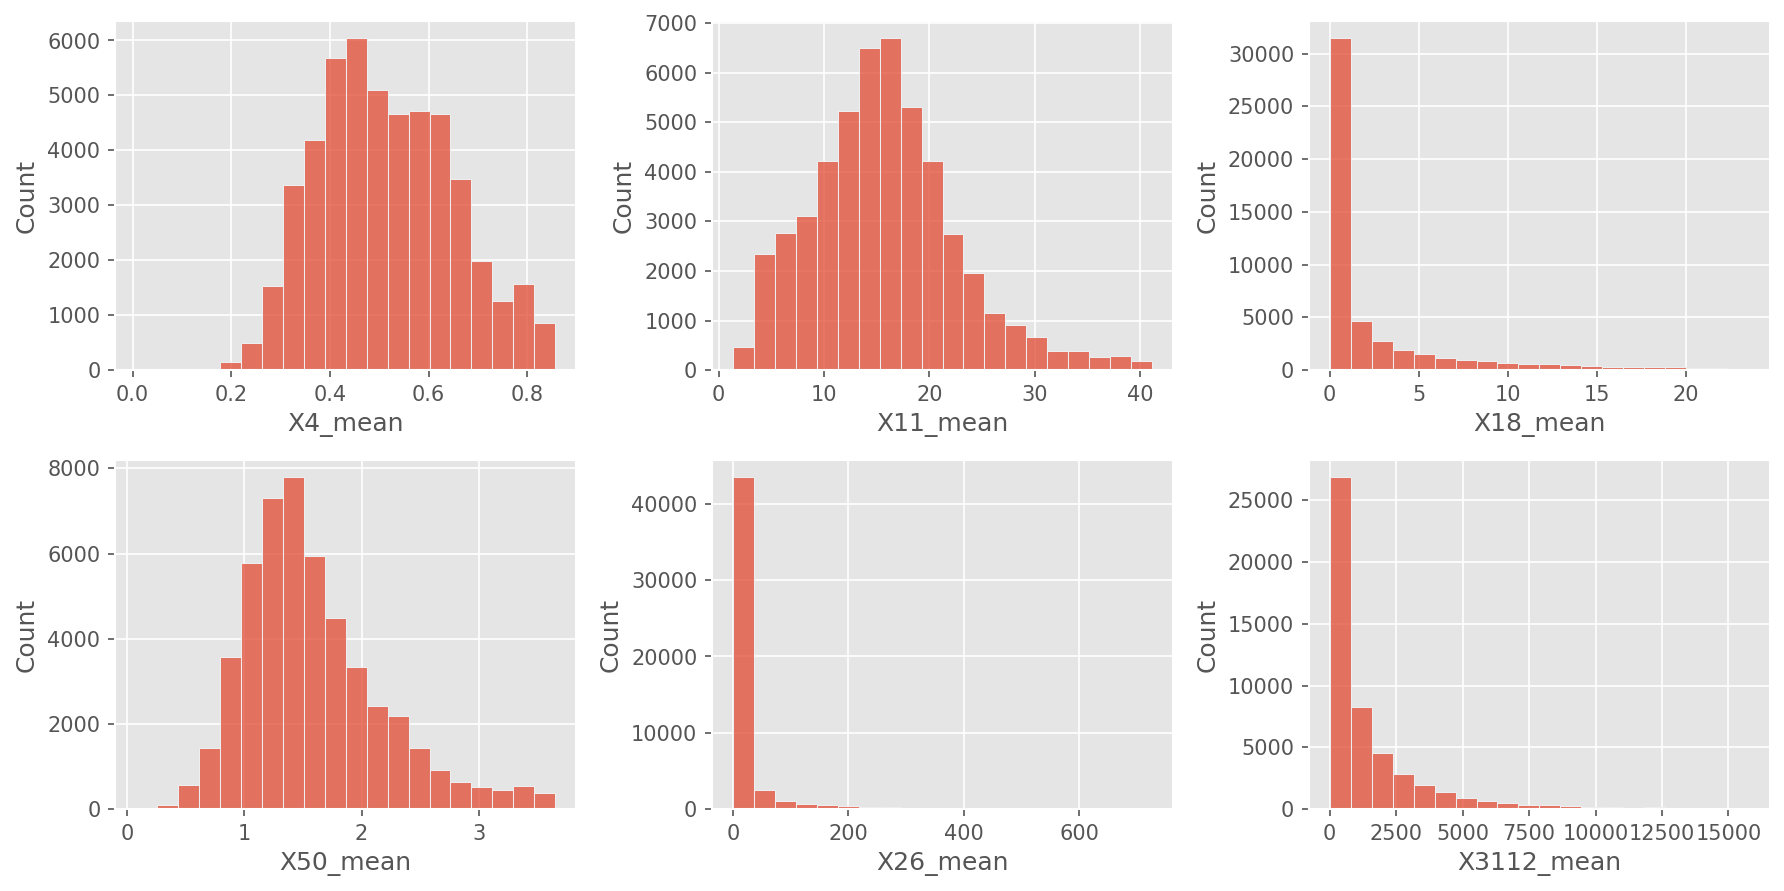

In [8]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()


In [9]:
# standardize response
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)

In [10]:
# normalize tabular inputs
tabular_input_sc = MinMaxScaler()
tabular_sc = tabular_input_sc.fit_transform(tabular)

## Image preprocessing functions

In [11]:
def process_image_from_file(file_path:str) -> tf.Tensor:
    # load the image
    img = tf.io.read_file(file_path)
    # decode the jpeg file 
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to 224 x 224 
    img = tf.image.resize(img, [224, 224])
    # preprocessing for efficient net 
    # per documentation, does nothing; including it
    # here for consistency
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, tabular, targets):
    return (process_image_from_file(file_path), tabular), targets


## Create training and validation sets

In [12]:
paths_train, paths_val, tabular_train, tabular_val, Y_train, Y_val = train_test_split(
    img_paths, tabular_sc, Y_sc, random_state=2, test_size=0.2
)

train_ds = tf.data.Dataset.from_tensor_slices((paths_train, tabular_train.astype(np.float32), Y_train.astype(np.float32)))
val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32), Y_val.astype(np.float32)))


# preprocess and batch
train_ds = train_ds.map(process_path).batch(CFG['BATCH_SIZE'])
val_ds = val_ds.map(process_path).batch(CFG['BATCH_SIZE'])

## Model architecture

In [13]:
keras.backend.clear_session()


############################## 
# IMG Processing
############################## 
img_input = keras.layers.Input(shape = (224, 224, 3), name="img_input")

img_backbone = keras.Sequential([
    # augmentation layers
    keras.Sequential([
        keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
        keras.layers.RandomTranslation(
            height_factor=0.1, width_factor=0.1, interpolation='nearest'
        ),
        keras.layers.RandomZoom(height_factor=(0.05, 0.15)),
        keras.layers.RandomFlip(mode="horizontal_and_vertical")
    ], name='augmentation'),
    EfficientNetV2B0(include_top=False, weights='imagenet'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(CFG['img_backbone_final_dim'])
], name='img_backbone')

# fix efficientnet weights 
img_backbone.get_layer('efficientnetv2-b0').trainable = False

img_output = img_backbone(img_input)

############################## 
# Tabular Processing
##############################
tabular_input = keras.layers.Input(shape = (tabular_sc.shape[1],) , name="tabular_input")

backbone_blocks = []
for i in range(CFG['n_tabular_layers']):
    backbone_blocks.extend([
        keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'tabular_block_{i}_dense'),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.1)
    ])
    
tabular_backbone = keras.Sequential(backbone_blocks, name='tabular_backbone')
tabular_output = tabular_backbone(tabular_input)

##############################
# Concat and outputs
##############################
output = keras.layers.Concatenate()([img_output, tabular_output])
for i in range(CFG['n_ff_layers']):
    output = keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'ff_block_{i}_dense')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.ReLU()(output)
    output = keras.layers.Dropout(0.1)(output)


output = keras.layers.Dense(6, name='output')(output)

model = keras.Model(inputs=[img_input, tabular_input], outputs=output)


num_steps_per_epoch = len(train_ds)
total_steps = CFG['NUM_EPOCHS'] * num_steps_per_epoch
warmup_steps = np.ceil(CFG['WARMUP_PCT'] * total_steps).astype(int)


lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 1e-5,
    decay_steps = total_steps - warmup_steps,
    warmup_target= CFG['MAX_LR'],
    warmup_steps = warmup_steps
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss= keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.R2Score()]
)

print(model.summary())

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 163)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_backbone        │ (None, 128)       │  6,083,280 │ img_input[0][0]   │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_backbone    │ (None, 128)       │     76,416 │ tabular_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ img_backbone[0][… │
│ (Concatenate)       │                   │            │ tabular_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_block_0_dense    │ (None, 256)       │     65,792 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ ff_block_0_dense… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_block_1_dense    │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ ff_block_1_dense… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,260,694 (23.88 MB)

 Trainable params: 339,846 (1.30 MB)

 Non-trainable params: 5,920,848 (22.59 MB)

None


## Training

In [14]:
history = model.fit(train_ds, validation_data=val_ds, epochs=CFG['NUM_EPOCHS'])

Epoch 1/25


2024-05-15 19:51:43.121424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 114s 301ms/step - loss: 1.5970 - r2_score: -0.6181 - val_loss: 0.9055 - val_r2_score: 0.0967
Epoch 2/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 1.0284 - r2_score: -0.0414 - val_loss: 0.8124 - val_r2_score: 0.1895
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - loss: 0.8802 - r2_score: 0.1090 - val_loss: 0.7710 - val_r2_score: 0.2310
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.8158 - r2_score: 0.1744 - val_loss: 0.7528 - val_r2_score: 0.2491
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - loss: 0.7837 - r2_score: 0.2067 - val_loss: 0.7474 - val_r2_score: 0.2547
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 83s 157ms/step - loss: 0.7606 - r2_score: 0.2302 - val_loss: 0.7432 - val_r2_score: 0.2587
Epoch 7/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - loss: 0.7490 - r2_score: 0.2419 - val_loss: 0.7419 - val_r2_score: 0.2601
Epoch 8/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - loss: 0.7362 - r2_score: 0.2549 - 

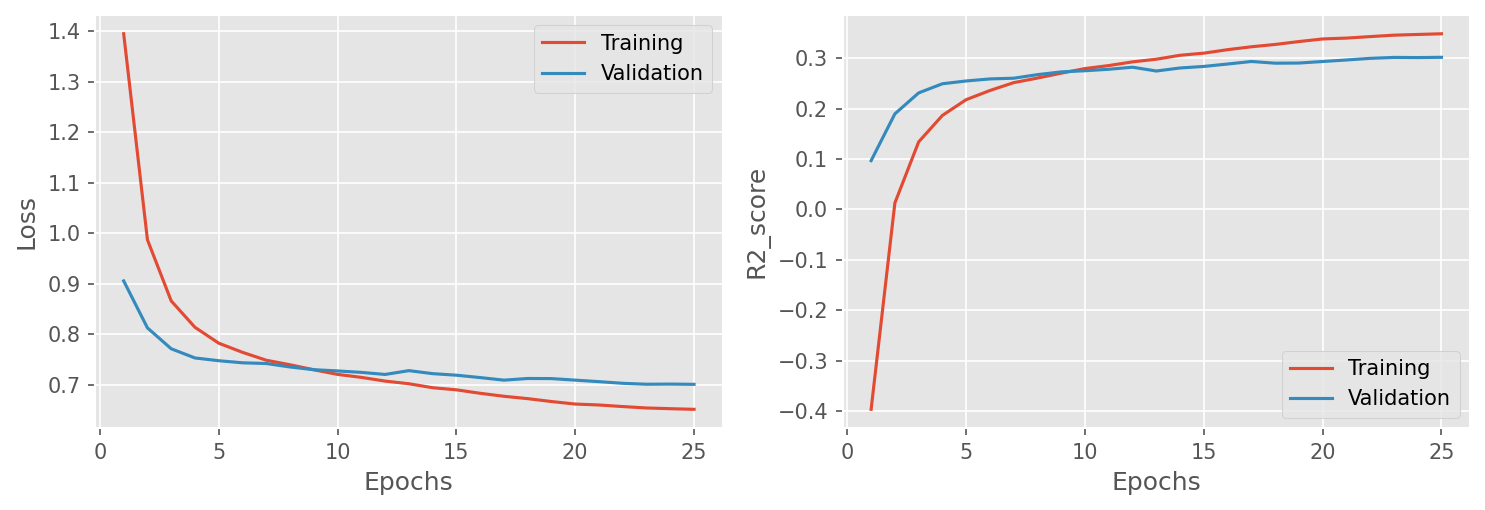

In [15]:
# plot training history
metrics = ['loss','r2_score']

fig,axs = plt.subplots(1, len(metrics), figsize=(5*len(metrics),3.5),dpi=150)

for i,metric in enumerate(metrics):
    
    _ = axs[i].plot(1 + np.arange(CFG['NUM_EPOCHS']), history.history[f'{metric}'],label='Training')
    _ = axs[i].plot(1 + np.arange(CFG['NUM_EPOCHS']), history.history[f'val_{metric}'],label='Validation')
    _ = axs[i].legend()
    _ = axs[i].set_ylabel(metric.capitalize())
    _ = axs[i].set_xlabel('Epochs')

fig.tight_layout()
fig.savefig('training_history.png',bbox_inches='tight')
fig.savefig('training_history.pdf',bbox_inches='tight')

In [16]:
# save weights
model.save_weights("model.weights.h5")

## Checking individual output R2

In [17]:
def process_paths_wo_targets(file_path, tabular):
    return ((process_image_from_file(file_path), tabular),)

# recreate the validation dataset without the targets
val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32)))
val_ds = val_ds.map(process_paths_wo_targets).batch(256)

y_val_pred = model.predict(val_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step


In [18]:
val_r2_scores = pd.Series(
    r2_score(Y_val, y_val_pred, multioutput='raw_values'),
    index=target_cols,
)
print(val_r2_scores)

X4_mean       0.278310
X11_mean      0.288158
X18_mean      0.465998
X50_mean      0.201063
X26_mean      0.239697
X3112_mean    0.336459
dtype: float64


## Predictions on Test Data

In [19]:
paths_test = test['img_path'].astype(str).values
tabular_test = tabular_input_sc.transform(
    test.drop(columns = ['id', 'img_path']).values
).astype(np.float32)
test_ds = tf.data.Dataset.from_tensor_slices((paths_test, tabular_test))
test_ds = test_ds.map(process_paths_wo_targets).batch(256)
predictions = model.predict(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 569ms/step


In [20]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()


submission.to_csv('submission.csv', index=False)

In [21]:
submission.head()

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.635624,11.043436,3.287175,1.556308,8.193558,-73.649918
1,202310319,0.378926,20.249176,0.325648,1.282804,7.103065,840.377136
2,202604412,0.580022,14.267813,2.489009,1.802721,32.922089,866.049866
3,201353439,0.467001,20.745924,0.791135,1.265631,11.061165,1626.895752
4,195351745,0.457768,10.457250,0.063838,1.494565,8.652871,-94.210953
